# Klasyfikacja mieszkań

# Analiza danych

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
data = pd.read_csv('train_data.csv')

### Analiza wstępna

In [ ]:
# data.info()
# data.describe()
data.head()
# data.isnull().sum()

# plt.hist(data['SalePrice'])
# plt.title("Sale Price")
# plt.show()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


### Etykietowanie

In [ ]:
data["Class"] = 0
data.loc[(data['SalePrice'] > 100000) & (data['SalePrice'] <= 350000), "Class"] = 1
data.loc[data["SalePrice"] > 350000, "Class"] = 2
data['Class'].value_counts()
data.drop('SalePrice', axis=1, inplace=True)

### Obróbka danych dyskretnych

In [ ]:
no_numeric_data = ["HallwayType", "HeatingType", "AptManageType", "SubwayStation"]
no_numeric_order_data = ["TimeToBusStop", "TimeToSubway"]

# for column in no_numeric_data + no_numeric_order_data:
#   print(data[column].value_counts())

# sprawdzenie czy każde mieszkanie które nie ma obok przystanku nie ma też metra -> TAK
# len(data[data['TimeToSubway'] == 'no_bus_stop_nearby']) == \
# len(data[(data['TimeToSubway'] == 'no_bus_stop_nearby') & (data['SubwayStation'] == 'no_subway_nearby')])

unique_times = data['TimeToBusStop'].dropna().unique()
time_mapping = {time: i for i, time in enumerate(unique_times)}
data['TimeToBusStop'] = data['TimeToBusStop'].map(time_mapping)

data.loc[data['TimeToSubway'] == 'no_bus_stop_nearby', 'TimeToBusStop'] = -1
mapping = {
    '0-5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
    'no_bus_stop_nearby': -1
}
data['TimeToSubway'] = data['TimeToSubway'].map(mapping)
data.loc[data['SubwayStation'] == 'no_subway_nearby', "TimeToSubway"] = -1

print(data['TimeToBusStop'].value_counts(dropna=False))
print(data['TimeToSubway'].value_counts(dropna=False))

for column in no_numeric_data:
  dummies = pd.get_dummies(data[column], drop_first=True)
  dummies = dummies.astype(int)
  data = pd.concat([data, dummies], axis=1)
  data = data.drop(column, axis=1)

# data.head()
data.drop('no_subway_nearby', axis=1, inplace=True)
data.info()

TimeToBusStop
 1    2984
 0     938
-1     164
 2      38
Name: count, dtype: int64
TimeToSubway
 0    1960
 3     682
 1     680
 2     526
-1     276
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YearBuilt                  4124 non-null   int64  
 1   Size(sqf)                  4124 non-null   int64  
 2   Floor                      4124 non-null   int64  
 3   N_Parkinglot(Ground)       4124 non-null   float64
 4   N_Parkinglot(Basement)     4124 non-null   float64
 5   TimeToBusStop              4124 non-null   int64  
 6   TimeToSubway               4124 non-null   int64  
 7   N_manager                  4124 non-null   float64
 8   N_elevators                4124 non-null   float64
 9   N_FacilitiesInApt          4124 non-null   int64  
 10  N_FacilitiesNearBy(Total)  4124 non-nu

### Korelacja danych

In [ ]:
import seaborn as sns

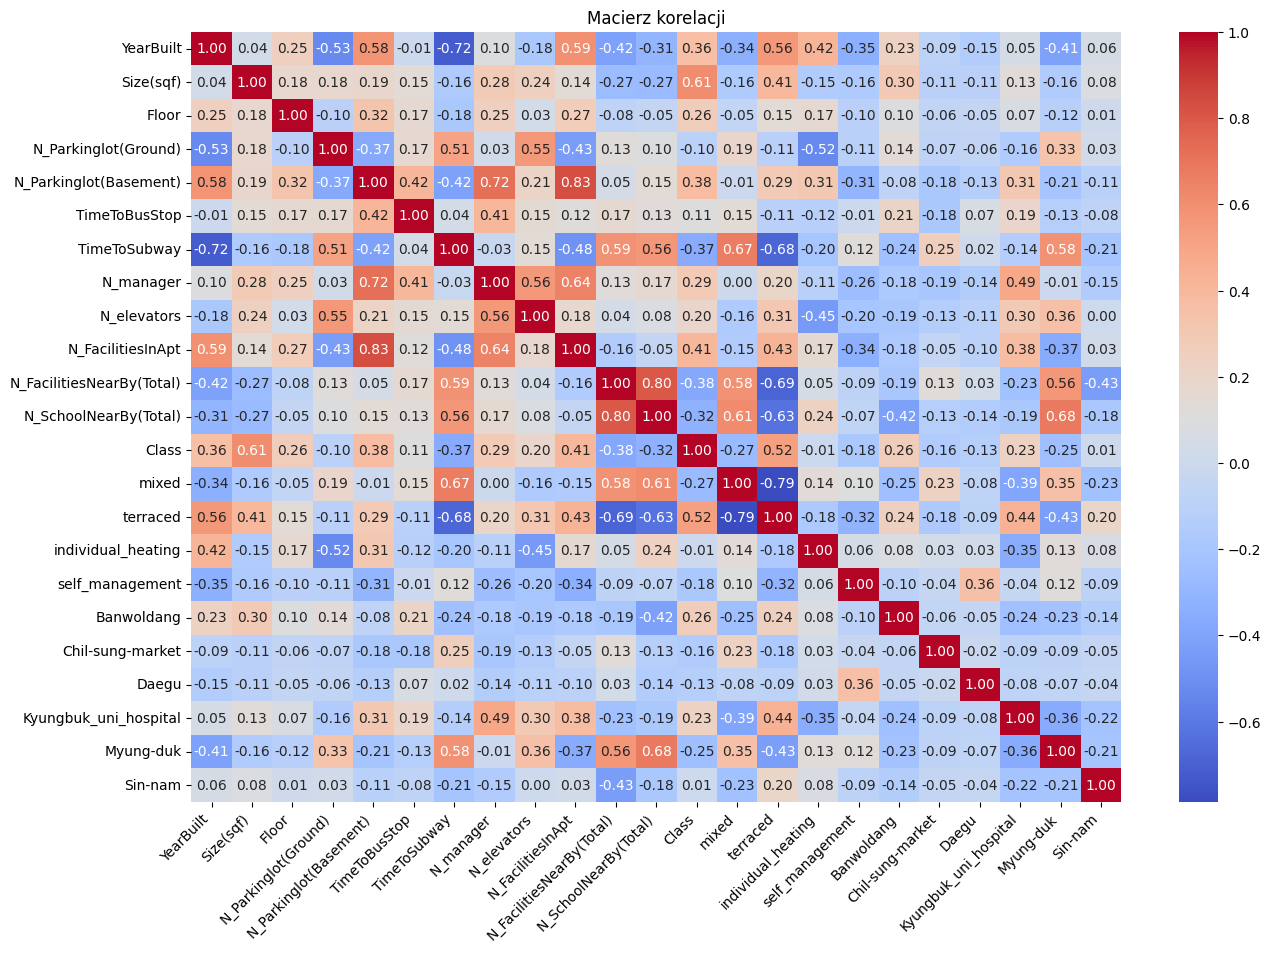

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(15, 10))  # Ustaw rozmiar wykresu
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Macierz korelacji')
plt.show()

In [ ]:
# odrzcenie nisko skorelowanych danych - współczynnik korelacji w przedziale [-0.2; 0.2]
data.drop(['N_Parkinglot(Ground)', 'TimeToBusStop','N_elevators', 'individual_heating',
           'self_management', 'Chil-sung-market', 'Daegu', 'Sin-nam'], axis=1, inplace=True)

# Model

In [ ]:
!nvidia-smi

Sun Mar 23 13:22:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P0             27W /   70W |     158MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Podział danych

In [ ]:
train, valid = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(train.drop('Class', axis=1).values, dtype=torch.float),
                              torch.tensor(train['Class'].values, dtype=torch.float))
valid_dataset = TensorDataset(torch.tensor(valid.drop('Class', axis=1).values, dtype=torch.float),
                              torch.tensor(valid['Class'].values, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

## Parametry modelu i procesu uczenia

In [ ]:
PARAMS = {
    'lr': 0.001,
    'epochs': 400,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'inputs': len(train_dataset[0][0]),
    'hidden': 128,
    'outputs': 1
}

## Architektura Modelu

In [ ]:
class ApartmentClassificator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ApartmentClassificator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## Pętla uczenia

In [ ]:
model = ApartmentClassificator(PARAMS['inputs'], PARAMS['hidden'], PARAMS['outputs']).to(PARAMS['device'])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=PARAMS['lr'])

for epoch in range(PARAMS['epochs']):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze(dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
            outputs = model(inputs)
            outputs = outputs.squeeze(dim=1)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)

    if epoch % 20 == 0:
      print(f'Epoch [{epoch+1}/{PARAMS["epochs"]}], Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss:.4f}')

Epoch [1/400], Train Loss: 0.1396, Valid Loss: 0.1567
Epoch [21/400], Train Loss: 0.1325, Valid Loss: 0.1114
Epoch [41/400], Train Loss: 0.1238, Valid Loss: 0.1095
Epoch [61/400], Train Loss: 0.1001, Valid Loss: 0.0992
Epoch [81/400], Train Loss: 0.1484, Valid Loss: 0.1293
Epoch [101/400], Train Loss: 0.0979, Valid Loss: 0.1017
Epoch [121/400], Train Loss: 0.1017, Valid Loss: 0.1062
Epoch [141/400], Train Loss: 0.0946, Valid Loss: 0.0970
Epoch [161/400], Train Loss: 0.0975, Valid Loss: 0.0978
Epoch [181/400], Train Loss: 0.1041, Valid Loss: 0.0978
Epoch [201/400], Train Loss: 0.0898, Valid Loss: 0.0969
Epoch [221/400], Train Loss: 0.1081, Valid Loss: 0.1024
Epoch [241/400], Train Loss: 0.1000, Valid Loss: 0.0986
Epoch [261/400], Train Loss: 0.0859, Valid Loss: 0.0996
Epoch [281/400], Train Loss: 0.0925, Valid Loss: 0.1003
Epoch [301/400], Train Loss: 0.0976, Valid Loss: 0.0992
Epoch [321/400], Train Loss: 0.0839, Valid Loss: 0.0949
Epoch [341/400], Train Loss: 0.0892, Valid Loss: 0.098

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Obliczenie accuracy
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(PARAMS['device']), labels.to(PARAMS['device'])
        outputs = model(inputs)
        outputs = outputs.squeeze(dim=1)

        # Konwersja na klasy
        predicted_classes = torch.zeros_like(outputs, dtype=torch.int64)  # Inicjalizacja tablicy z klasami
        predicted_classes[outputs <= 0.5] = 0  # Klasa 'cheap'
        predicted_classes[(outputs > 0.5) & (outputs <= 1.5)] = 1  # Klasa 'average'
        predicted_classes[outputs > 1.5] = 2  # Klasa 'expensive'


        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_classes.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)

# Wyświetlenie accuracy
print(f'Epoch [{epoch+1}/{PARAMS["epochs"]}], Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy:.4f}')

Epoch [400/400], Train Loss: 0.1086, Valid Loss: 0.1012, Valid Accuracy: 0.8388


## Predykcje modelu

### Import i preprocessing danych

In [ ]:
test = pd.read_csv('test_data.csv')

no_numeric_data = ["HallwayType", "HeatingType", "AptManageType", "SubwayStation"]
no_numeric_order_data = ["TimeToBusStop", "TimeToSubway"]

unique_times = test['TimeToBusStop'].dropna().unique()
time_mapping = {time: i for i, time in enumerate(unique_times)}
test['TimeToBusStop'] = test['TimeToBusStop'].map(time_mapping)

test.loc[test['TimeToSubway'] == 'no_bus_stop_nearby', 'TimeToBusStop'] = -1
mapping = {
    '0-5min': 0,
    '5min~10min': 1,
    '10min~15min': 2,
    '15min~20min': 3,
    'no_bus_stop_nearby': -1
}
test['TimeToSubway'] = test['TimeToSubway'].map(mapping)
test.loc[test['SubwayStation'] == 'no_subway_nearby', "TimeToSubway"] = -1

for column in no_numeric_data:
  dummies = pd.get_dummies(test[column], drop_first=True)
  dummies = dummies.astype(int)
  test = pd.concat([test, dummies], axis=1)
  test = test.drop(column, axis=1)

test.drop('no_subway_nearby', axis=1, inplace=True)
test.drop(['N_Parkinglot(Ground)', 'TimeToBusStop','N_elevators', 'individual_heating',
           'self_management', 'Chil-sung-market', 'Daegu', 'Sin-nam'], axis=1, inplace=True)

In [ ]:
test.columns

Index(['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor',
       'N_Parkinglot(Basement)', 'TimeToSubway', 'N_manager',
       'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)',
       'N_SchoolNearBy(Total)', 'mixed', 'terraced', 'Banwoldang',
       'Kyungbuk_uni_hospital', 'Myung-duk'],
      dtype='object')

### Wykonanie predykcji

In [ ]:
import numpy as np

In [ ]:
test_dataset = TensorDataset(torch.tensor(test.values, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()

all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(PARAMS['device'])
        outputs = model(inputs)
        all_predictions.extend(outputs.cpu().numpy())

all_predictions = np.concatenate(all_predictions)

predicted_classes = np.zeros_like(all_predictions, dtype=object)
predicted_classes[all_predictions <= 0.5] = 'cheap'
predicted_classes[(all_predictions > 0.5) & (all_predictions <= 1.5)] = 'average'
predicted_classes[all_predictions > 1.5] = 'expensive'

In [ ]:
pd.DataFrame({'Class': predicted_classes}).to_csv('predictions.csv', index=False)